In [1]:
import torch
from torchvision.transforms.functional import to_pil_image 

import matplotlib.pyplot as plt
import numpy as np

from rf import RF
from dit import DiT_Llama

In [2]:
model_id = "rf_cifar_99_16:46:48"
epoch_idx = 100

model = DiT_Llama(3, 32, dim=128, n_layers=5, n_heads=4, num_classes=10).cuda()
model.load_state_dict(torch.load(f"weights/{model_id}"))
rf = RF(model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0053710938..1.0474975].


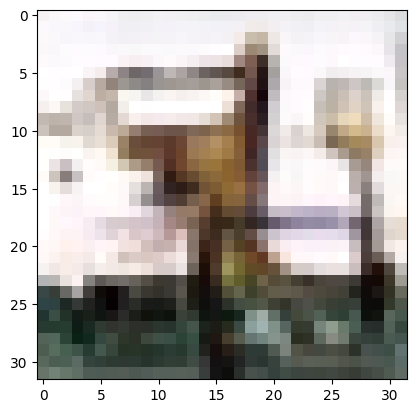

In [3]:
z = torch.randn(1,3,32,32).cuda()
c = torch.tensor([7]).cuda()

out = rf.sample(z, c, sample_steps=50)
#to_pil_image(out[-1][0])
plt.imshow(
    np.moveaxis(
        out[-1][0].detach().cpu().numpy() * 0.5 + 0.5, 0, -1
    )
)

## Jacobian

In [4]:
from torch.autograd.functional import jacobian

def sample(z, cond, null_cond=None, sample_steps=50, cfg=2.0):
    b = z.size(0)
    dt = 1.0 / sample_steps
    dt = torch.tensor([dt] * b).to(z.device).view([b, *([1] * len(z.shape[1:]))])
    images = [z]
    for i in range(sample_steps, 0, -1):
        t = i / sample_steps
        t = torch.tensor([t] * b).to(z.device)

        vc = model(z, t, cond)
        if null_cond is not None:
            vu = model(z, t, null_cond)
            vc = vu + cfg * (vc - vu)

        z = z - dt * vc
        images.append(z)
        
    return images

c_idx = 7

def sample_v(v):
    c = torch.tensor([c_idx]).cuda()
    noise = torch.reshape(v, (1, 3, 32, 32))
    out = sample(noise, c, sample_steps=50)
    return torch.reshape(out[-1], (3072,))

v = torch.randn((3072,)).cuda()

print("Jacobian")
J = jacobian(sample_v, v)

print("svd")
svd = torch.svd(
    torch.tensor(
        J, 
        dtype=torch.float32
    )
)

Jacobian
svd


/tmp/ipykernel_27164/1819265718.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


In [5]:
svd.S

tensor([1.4015e+01, 1.1425e+01, 1.0251e+01,  ..., 8.5175e-03, 8.3256e-03,
        7.6137e-03], device='cuda:0')

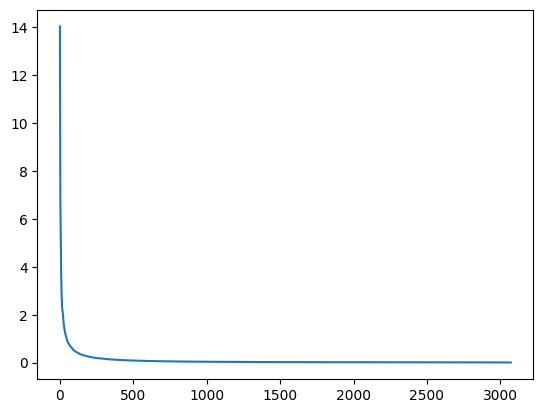

In [6]:
plt.plot(svd.S.detach().cpu().numpy())

In [7]:
def plot_sv_distribution(S, sigma, title="rflow_sv_distribution"):
    plt.plot(S)
    #title += f"_%.3f" % sigma
    title += f"epoch_{epoch_idx}.jpg"
    plt.title(f"Singular values for epoch {epoch_idx}" )
    plt.savefig(title, dpi=300)

def plot_top_sv(U, S, sigma, n_top=100, title="rflow_top"):

    if n_top==100:
        fig, axs = plt.subplots(10, 10, figsize=(50, 50))
    elif n_top==625:
        fig, axs = plt.subplots(25, 25, figsize=(70, 70))
    
    axs = axs.flatten()
    
    for j in range(n_top):
        top_sv = U[:, j]
        #top_sv_np = pipe.postprocess_image(torch.reshape(torch.tensor(top_sv), (3, 64, 64))[None, :], "np")[0]
        #axs[j].imshow(top_sv_np)
        top_sv_tensor = torch.reshape(torch.tensor(top_sv), (3, 32, 32))
        
        top_sv_tensor /= torch.max(torch.abs(top_sv_tensor)) 
        top_sv_tensor = top_sv_tensor / 2 + 0.5
        axs[j].imshow(np.moveaxis(top_sv_tensor.numpy(), 0, -1))
        axs[j].set_title(f"$sv = %.3f$" % S[j] )

    title += f"_{n_top}"
    title += f"_%.3f" % sigma
    title += f"_epoch_{epoch_idx}.jpg"
    plt.savefig(title, dpi=400)

    plt.tight_layout()

In [8]:
S = svd.S.detach().cpu().numpy()
U = svd.U.detach().cpu().numpy()
V = svd.V.detach().cpu().numpy()

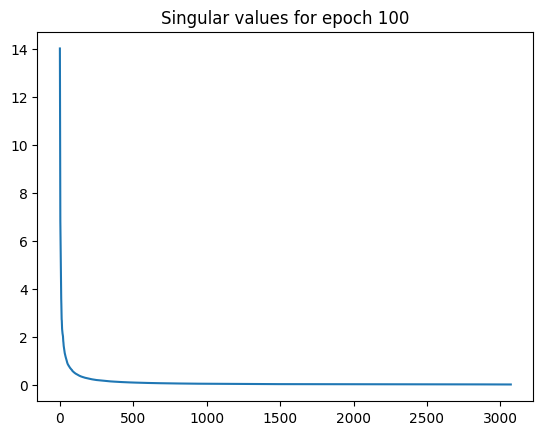

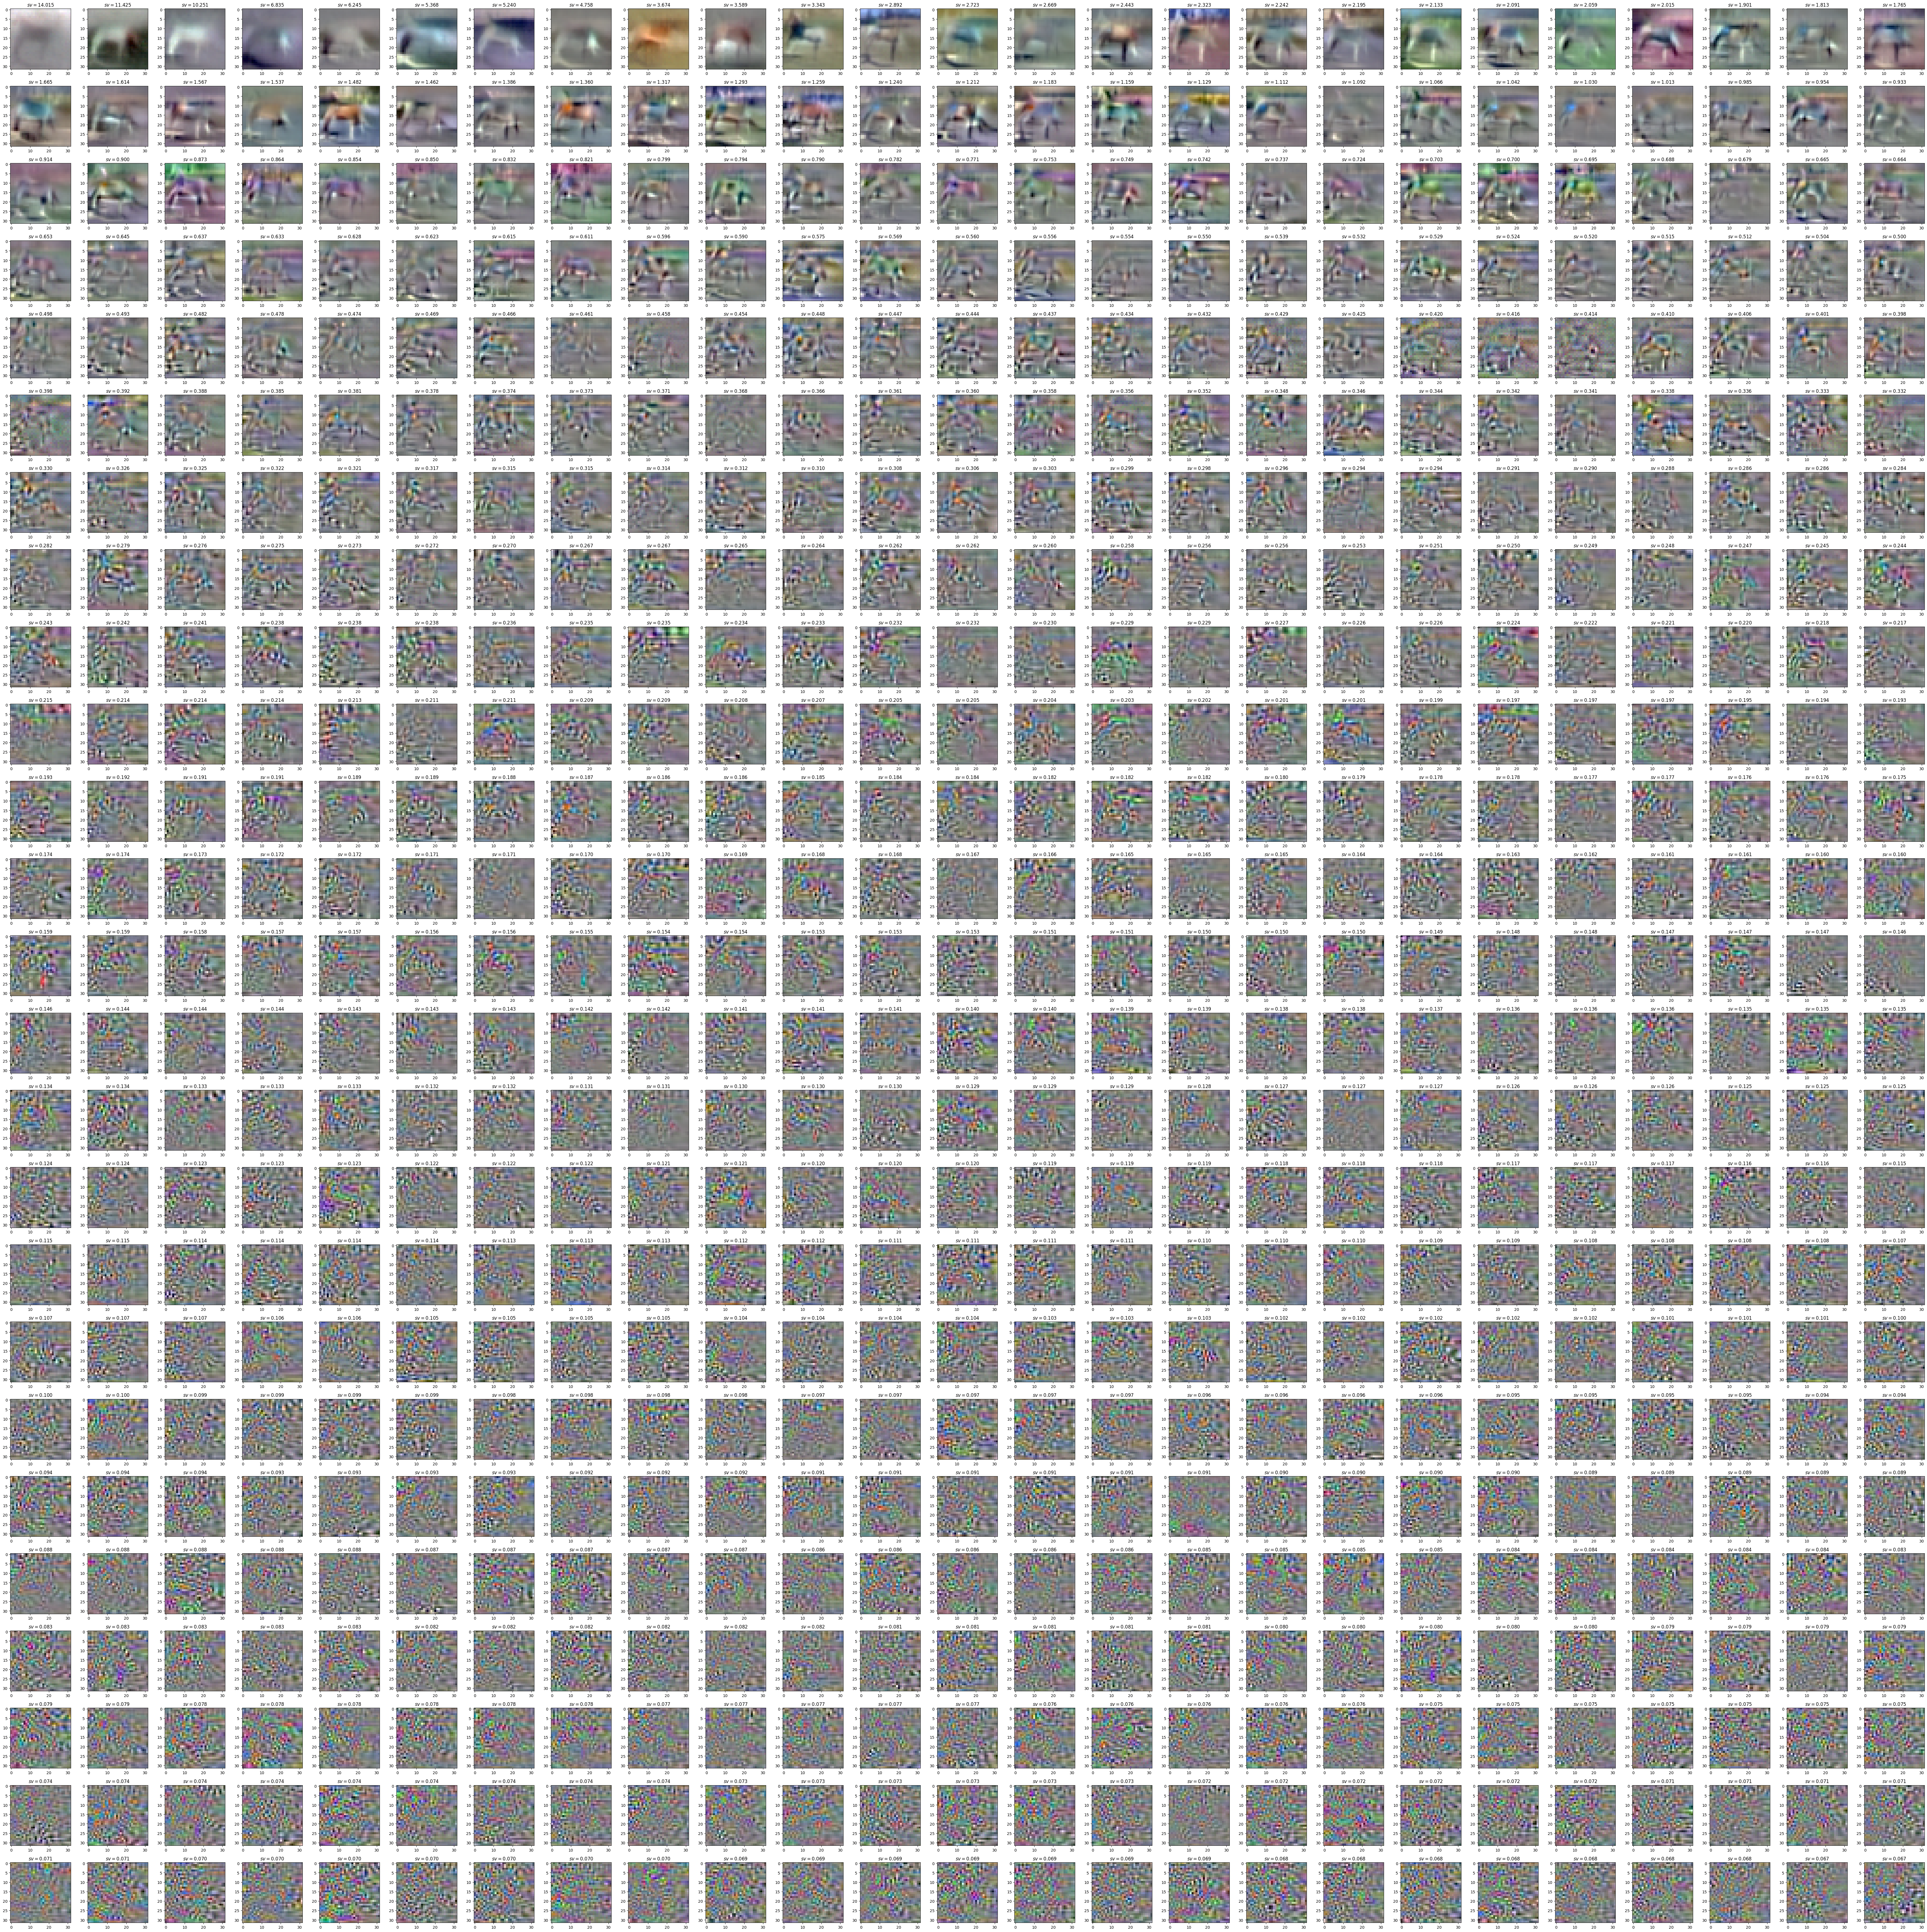

In [9]:
plot_sv_distribution(S, 1)
plot_top_sv(V, S, 1, n_top=625)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.180752..2.156234].


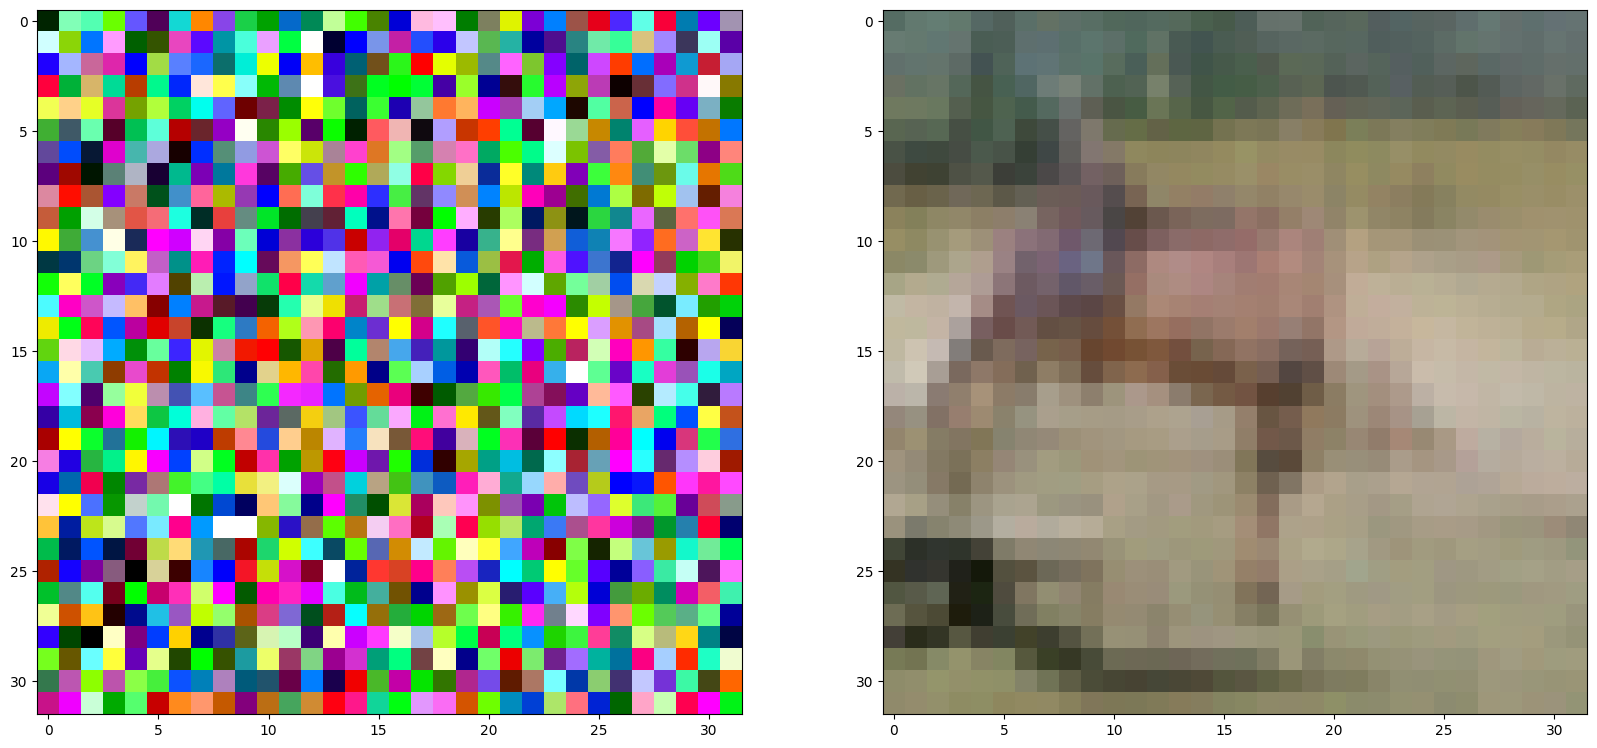

In [10]:
out = rf.sample(v.view((1,3,32,32)), torch.tensor([c_idx]).cuda(), sample_steps=50)
fig, axs = plt.subplots(1, 2, figsize=(20, 20)) 

axs[0].imshow(
    np.moveaxis(
        v.view((3,32,32)).detach().cpu().numpy() * 0.5 + 0.5, 0, -1
    )
)

axs[1].imshow(
    np.moveaxis(
        out[-1][0].detach().cpu().numpy() * 0.5 + 0.5, 0, -1
    )
)

plt.savefig(f"start_end_{epoch_idx}.jpg",dpi=400)


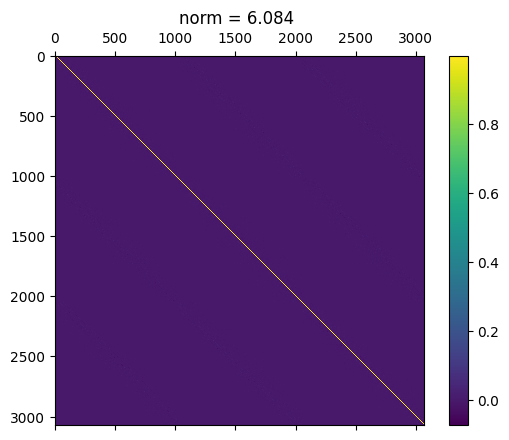

In [11]:
device="cuda"
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(svd.U.cpu() @ svd.V.t().cpu(), interpolation='nearest')
fig.colorbar(cax)

ax.set_title("norm = %.3f " % torch.norm(svd.U @ svd.V.t() - torch.eye(3072).to(device)).item())
plt.savefig(f"denoiser_diag_{epoch_idx}.jpg",dpi=400)